# NCAAM20

## Problem definition
> Google Cloud & NCAA® ML Competition 2020-NCAAM (https://www.kaggle.com/c/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/overview)

## Data


## Evaluation
LogLoss

### What will be covered
1. Import of common libraries
2. Data ingestion & cleaning
3. Data Analysis and visualization
4. Feature Selection
5. ML model selection
6. ML model tuning
7. Results visualizations
8. Model export
9. Python and html generation

#### Assumptions
* Data is provided with a single csv file with an header representing the columns'names

### Parameters

In [29]:
INPUT_DATA_FILE = 'data/data.csv'
INSTALL_LIBRARIES = False
REMOVE_ROWS_WITH_INVALID_COLS = True #if False then a SimpleImputer will be used
MATPLOT_STYLE = 'seaborn-dark-palette'
TARGET_COLUMN = 'result'
#if different from None it represents the number of wanted features in the feature selection step
NUM_FEATURES = None
MODEL_EXP_PATH = 'bestClassifier.joblib'
OUTPUT_SCRIPT_NAME = 'modelPython.py'
OUTPUT_HTML_NAME = 'model_report.html'
MODEL_EXPORT = False
REPORT_GEN = False

columns_to_remove =[]

#not include the target in this list
column_to_visualize = ['Seed_1', 'Seed_2', 'Seed_diff', 'Seed_ratio', 'Score_ratio', 'Count_ratio', 'Var_ratio', 'Mean_score1', 'Mean_score2', 'Mean_score_diff', 'Mean_score_ratio']

column_names_and_types= {
         'DayNum': 'int64',
         'DayZero': 'datetime64',
         'Season': 'str',
         'Seed_1': 'int64',
         'Seed_2': 'int64',
         'Seed_diff' : 'int64',
         'Seed_ratio' : 'float64',
         'Score_ratio' : 'float64',
         'Count_ratio' : 'float64',
         'Var_ratio' : 'float64',
         'Mean_score1' : 'float64',
         'Mean_score2' : 'float64',
         'Mean_score_diff' : 'float64',
         'Mean_score_ratio' : 'float64'}

#this manage eventually data errors in the dataset using coerce
numeric_features = ['DayNum','Seed_1','Seed_2','Seed_diff','Seed_ratio','Score_ratio','Count_ratio','Var_ratio','Mean_score1','Mean_score2','Mean_score_diff','Mean_score_ratio']
datetime_features = ['DayZero']


from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#this will be used in step 5
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=30, max_features=0.6, n_jobs=-1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

### 1-Import of common libraries

In [30]:
if INSTALL_LIBRARIES:
    import sys
    !conda install --yes --prefix {sys.prefix} matplotlib
    !conda install --yes --prefix {sys.prefix} numpy
    !conda install --yes --prefix {sys.prefix} pandas
    !conda install --yes --prefix {sys.prefix} scikit-learn
    !conda install --yes --prefix {sys.prefix} ipython
    !conda install --yes --prefix {sys.prefix} seaborn

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from sklearn import metrics
from IPython.display import display
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import json
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pprint
import heapq
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


%matplotlib inline



plt.style.use(MATPLOT_STYLE)
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (26, 20),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)

### 2-Data ingestion & cleaning

In [31]:
raw_input_df = pd.read_csv(INPUT_DATA_FILE, infer_datetime_format=True, index_col=False, skipinitialspace=True)

In [32]:
#Here insert needed specific data cleaning and transformation steps



In [33]:
raw_input_df = raw_input_df.drop(columns=columns_to_remove)

raw_input_df[numeric_features] = raw_input_df[numeric_features].apply(pd.to_numeric, errors='coerce')
raw_input_df= raw_input_df.astype(column_names_and_types, copy=False, errors='ignore')
raw_input_df[datetime_features] = raw_input_df[datetime_features].apply(pd.to_datetime, format='%Y/%m/%d %H:%M')

if REMOVE_ROWS_WITH_INVALID_COLS:
    raw_input_df = raw_input_df.dropna()
else:
    #TODO: simpleimpute numerical values
    pass

display(raw_input_df.head())
display(raw_input_df.describe())
display(raw_input_df.info())

DayNum    DayZero Season  Seed_1  Seed_2  Seed_diff  Seed_ratio  \
0     136 1998-10-26   1999       4      13         -9    0.307692   
1     136 1998-10-26   1999       1      16        -15    0.062500   
2     136 1998-10-26   1999       1      16        -15    0.062500   
3     136 1998-10-26   1999      10       7          3    1.428571   
4     136 1998-10-26   1999      12       5          7    2.400000   

   Score_ratio  Count_ratio  Var_ratio  Mean_score1  Mean_score2  \
0     1.181114     0.778163   1.378877    83.485523    55.003466   
1     1.457779     1.240356   1.246019    75.703349    64.412463   
2     1.076057     0.870518   1.274071    75.208238    60.842629   
3     0.821615     0.839034   1.062015    69.750600    71.229376   
4     0.816601     0.813253   0.740166    70.713580    70.423695   

   Mean_score_diff  Mean_score_ratio  result  
0        28.482057          1.517823       1  
1        11.290886          1.175290       1  
2        14.365609          1.236111       1  
3        -1.478777          0.979239       1  
4         0.289885          1.004116       1

DayNum       Seed_1       Seed_2    Seed_diff   Seed_ratio  \
count  2738.000000  2738.000000  2738.000000  2738.000000  2738.000000   
mean    139.075237     6.963112     6.963112     0.000000     2.326727   
std       4.218481     4.676111     4.676111     7.504036     3.323305   
min     134.000000     1.000000     1.000000   -15.000000     0.062500   
25%     136.000000     3.000000     3.000000    -5.000000     0.333333   
50%     137.000000     6.000000     6.000000     0.000000     1.000000   
75%     139.000000    11.000000    11.000000     5.000000     3.000000   
max     154.000000    16.000000    16.000000    15.000000    16.000000   

       Score_ratio  Count_ratio    Var_ratio  Mean_score1  Mean_score2  \
count  2738.000000  2738.000000  2738.000000  2738.000000  2738.000000   
mean      1.052144     0.847505     1.052884    72.883098    60.911026   
std       0.461986     0.136991     0.172355    13.366544    10.125334   
min       0.123109     0.290016     0.559581     9.563408    11.567916   
25%       0.907953     0.761628     0.935600    69.668295    55.736855   
50%       1.000000     0.828250     1.042070    73.322091    60.226561   
75%       1.101379     0.899225     1.155351    76.875916    65.053909   
max       8.122887     1.783529     1.870855   324.595628   124.811765   

       Mean_score_diff  Mean_score_ratio       result  
count      2738.000000       2738.000000  2738.000000  
mean         11.972072          1.263034     0.500000  
std          21.010146          0.594389     0.500091  
min        -107.186435          0.101776     0.000000  
25%           5.379464          1.082661     0.000000  
50%          12.834404          1.212783     0.500000  
75%          20.725086          1.369472     1.000000  
max         304.964884         16.535064     1.000000

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2738 entries, 0 to 2737
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DayNum            2738 non-null   int64         
 1   DayZero           2738 non-null   datetime64[ns]
 2   Season            2738 non-null   object        
 3   Seed_1            2738 non-null   int64         
 4   Seed_2            2738 non-null   int64         
 5   Seed_diff         2738 non-null   int64         
 6   Seed_ratio        2738 non-null   float64       
 7   Score_ratio       2738 non-null   float64       
 8   Count_ratio       2738 non-null   float64       
 9   Var_ratio         2738 non-null   float64       
 10  Mean_score1       2738 non-null   float64       
 11  Mean_score2       2738 non-null   float64       
 12  Mean_score_diff   2738 non-null   float64       
 13  Mean_score_ratio  2738 non-null   float64       
 14  result            2738 n

None

### 3-Data Analysis and visualization

In [34]:
input_features = column_to_visualize
column_to_visualize.append(TARGET_COLUMN)

plt.figure(figsize=(20,15))
sns.pairplot(raw_input_df[column_to_visualize].sample(frac=0.5), kind="reg", hue=TARGET_COLUMN, corner=True, diag_kind="kde", height=16)
plt.suptitle('Pair Plot Features', size = 28);

<Figure size 1440x1080 with 0 Axes>

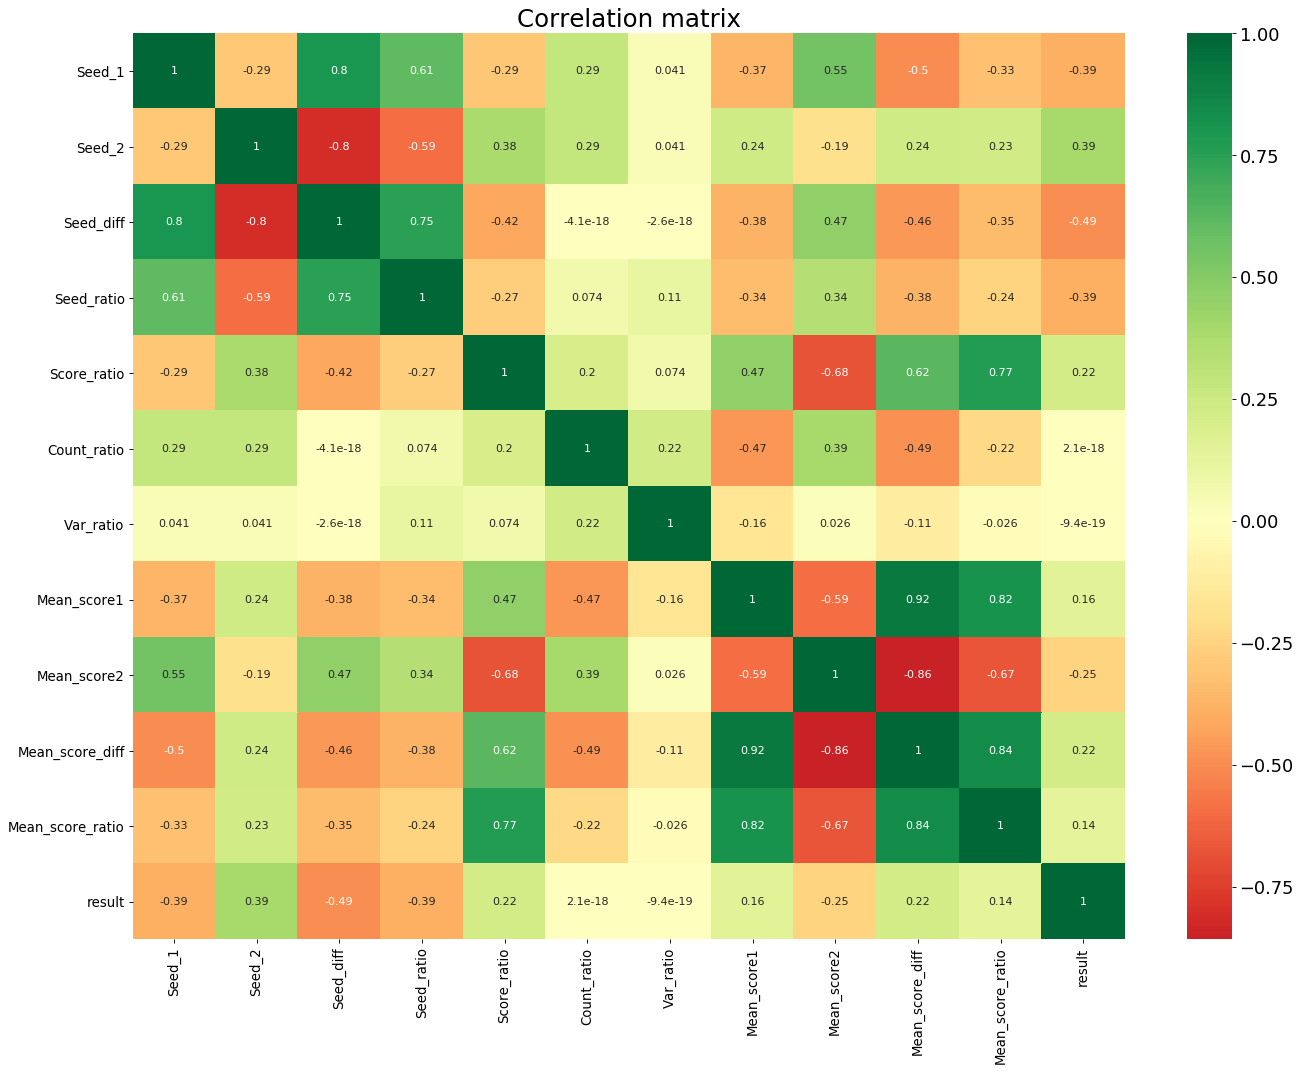

In [35]:
plt.figure(figsize=(20,15), dpi= 80)
sns.heatmap(raw_input_df[column_to_visualize].corr(), xticklabels=raw_input_df[column_to_visualize].corr().columns, yticklabels=raw_input_df[column_to_visualize].corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlation matrix', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

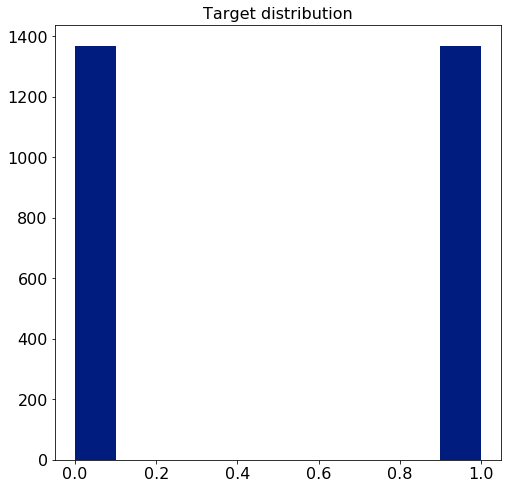

In [41]:
raw_input_df[TARGET_COLUMN].plot(kind='hist', subplots=True, figsize=(8, 8))
plt.title("Target distribution")
plt.ylabel("")
plt.show()

### 4-Feature Selection

In [42]:
input_features.remove(TARGET_COLUMN)
new_features = input_features
if NUM_FEATURES and NUM_FEATURES <= len(input_features):
    #feature_names = list(raw_input_df.columns.values)
    
    # Create and fit selector
    select_k_best_classifier = SelectKBest(f_classif, k=NUM_FEATURES)
    fit_transofrmed_features = select_k_best_classifier.fit_transform(raw_input_df[input_features], raw_input_df[TARGET_COLUMN])
    
    mask = select_k_best_classifier.get_support() #list of booleans
    new_features = [] # The list of your K best features

    for bool, feature in zip(mask, input_features):
        if bool:
            new_features.append(feature)
            
    print("Selected features are: %s" % new_features)
    input_df_reduced = pd.DataFrame(fit_transofrmed_features, columns=new_features)
    input_df_reduced[TARGET_COLUMN] = raw_input_df[TARGET_COLUMN].to_numpy()
    display(input_df_reduced.head())
    display(input_df_reduced.describe())
    display(input_df_reduced.info())
else:
    input_df_reduced = raw_input_df

ValueError: list.remove(x): x not in list

### 5-ML model selection

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

# preprocess dataset, split into training and test part
X = input_df_reduced[numeric_features]
y = input_df_reduced[TARGET_COLUMN]
print(X.dtypes)
X = StandardScaler().fit_transform(X) #ATTENTION: for each prediction we need to fit_transform first
X_train, X_validation, y_train, y_validation = \
    train_test_split(X, y, test_size=.3, random_state=42)
X_validation, X_test, y_validation, y_test = \
    train_test_split(X_validation, y_validation, test_size=.2, random_state=42)

#HERE MACROAVG_F1 IS USED, CHANGE IT IF YOU NEED
indexBestClassifier = 0
maxScore = 0
actualIndex = 0

# iterate over classifiers
for name, clf in zip(names, classifiers):
    print("#"*10)
    print("Trying with classifier: {}".format(clf))
    clf.fit(X_train, y_train)
    score = clf.score(X_validation, y_validation)
    clf_report = classification_report(y_validation, clf.predict(X_validation), output_dict=True)
    print(json.dumps(clf_report,sort_keys=True, indent=4))
    score_to_use = float(clf_report["weighted avg"]["f1-score"])
    if score_to_use > maxScore:
        maxScore = score_to_use
        indexBestClassifier = actualIndex
    actualIndex +=1
    
print("The best classifier is: {} with score {}".format(classifiers[indexBestClassifier], maxScore))

### 6-ML model tuning - to be modified manually

In [ ]:
params = {
    'activation' : ['identity', 'logistic', 'tanh', 'relu'],
    'alpha' : [0.0001, 0.001, 0.01, 0.1],
    'learning_rate' : ['constant', 'invscaling', 'adaptive']
}

param_to_be_varied_in_validation_curve = 'alpha'
param_range_valid_curve = [0.0001, 0.001, 0.01, 0.1]

clf_best = RandomizedSearchCV(classifiers[indexBestClassifier], params, n_iter = 5, scoring='f1_weighted', random_state=42).fit(X,y)
#clf_best = GridSearchCV(classifiers[indexBestClassifier], params, scoring='f1_weighted').fit(X,y)
best_estimator = clf_best.best_estimator_
bestScore = clf_best.best_score_
results = pd.DataFrame(clf_best.cv_results_)
print("Results from hyperParams search: ")
print(json.dumps(results.to_dict(),indent=4))
print("Best classifier found: {} with score {}".format(best_estimator,bestScore))

### 7-Results visualizations

Score:  0.8303030303030303
Misclassified len:  28
corrected_examples len:  137


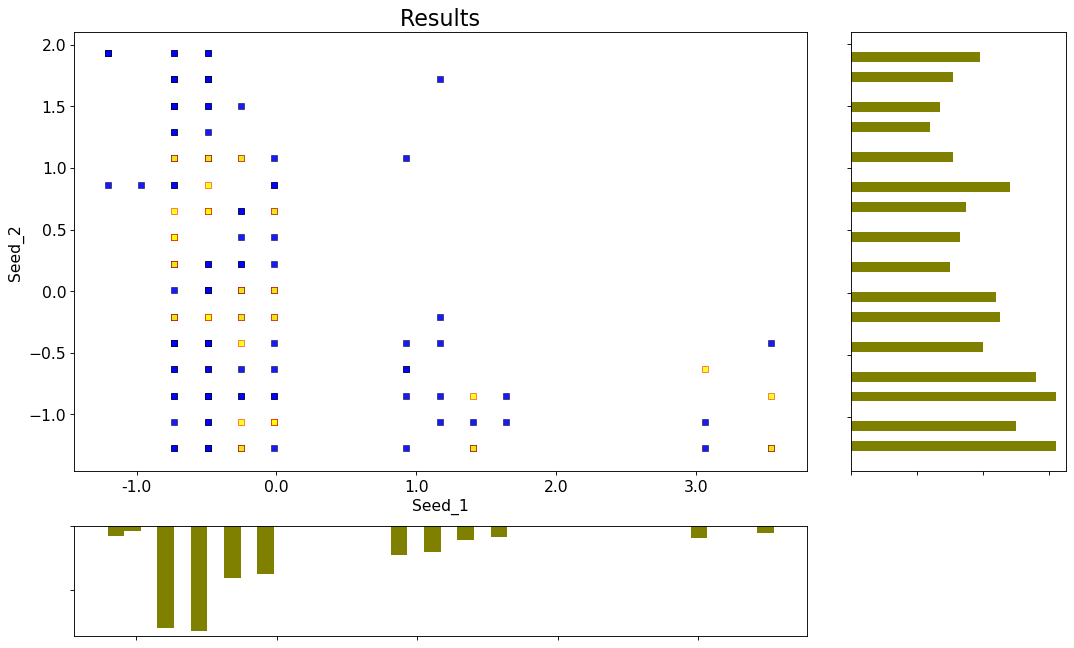

In [48]:
#Plot a scatter using the first 2 most important features and colour in red the yellow 
y_pred = best_estimator.predict(X_test)
print("Score: ",best_estimator.score(X_test,y_test))
misclassified_examples = X_test[y_test != y_pred]
print("Misclassified len: ",len(misclassified_examples))
misclassified_examples = pd.DataFrame(misclassified_examples,columns=new_features)
corrected_examples = X_test[y_test == y_pred]
print("corrected_examples len: ",len(corrected_examples))
corrected_examples = pd.DataFrame(corrected_examples,columns=new_features)
if NUM_FEATURES:
    list_scores = list(select_k_best_classifier.scores_)
    print("list_scores: ",list_scores)
    two_best_scores = heapq.nlargest(2, list_scores)
    print("two_best_scores: ",two_best_scores)
    best_feature_one = input_features[list_scores.index(two_best_scores[0])]
    print("best_feature_one: ",best_feature_one)
    best_feature_two = input_features[list_scores.index(two_best_scores[1])]
    print("best_feature_two: ",best_feature_two)
else:
    best_feature_one = input_features[0]
    best_feature_two = input_features[1]
# Create Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])


# Scatterplot on main ax
ax_main.scatter(corrected_examples[best_feature_one], corrected_examples[best_feature_two], label='correct',marker="s", c='blue', alpha=.9, cmap="tab10", edgecolors='black', linewidths=.5)
ax_main.scatter(misclassified_examples[best_feature_one], misclassified_examples[best_feature_two], label='errors',marker="s", c='yellow', alpha=.9, cmap="tab10", edgecolors='red', linewidths=.5)

X_validation_df = pd.DataFrame(X_validation,columns=new_features)

# histogram on the right
ax_bottom.hist(X_validation_df[best_feature_one], 40, histtype='stepfilled', orientation='vertical', color='olive')
ax_bottom.invert_yaxis()

# histogram in the bottom
ax_right.hist(X_validation_df[best_feature_two], 40, histtype='stepfilled', orientation='horizontal', color='olive')

# Decorations
ax_main.set(title='Results', xlabel=best_feature_one, ylabel=best_feature_two)
ax_main.title.set_fontsize(20)
for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
    item.set_fontsize(14)

xlabels = ax_main.get_xticks().tolist()
ax_main.set_xticklabels(xlabels)
plt.show()

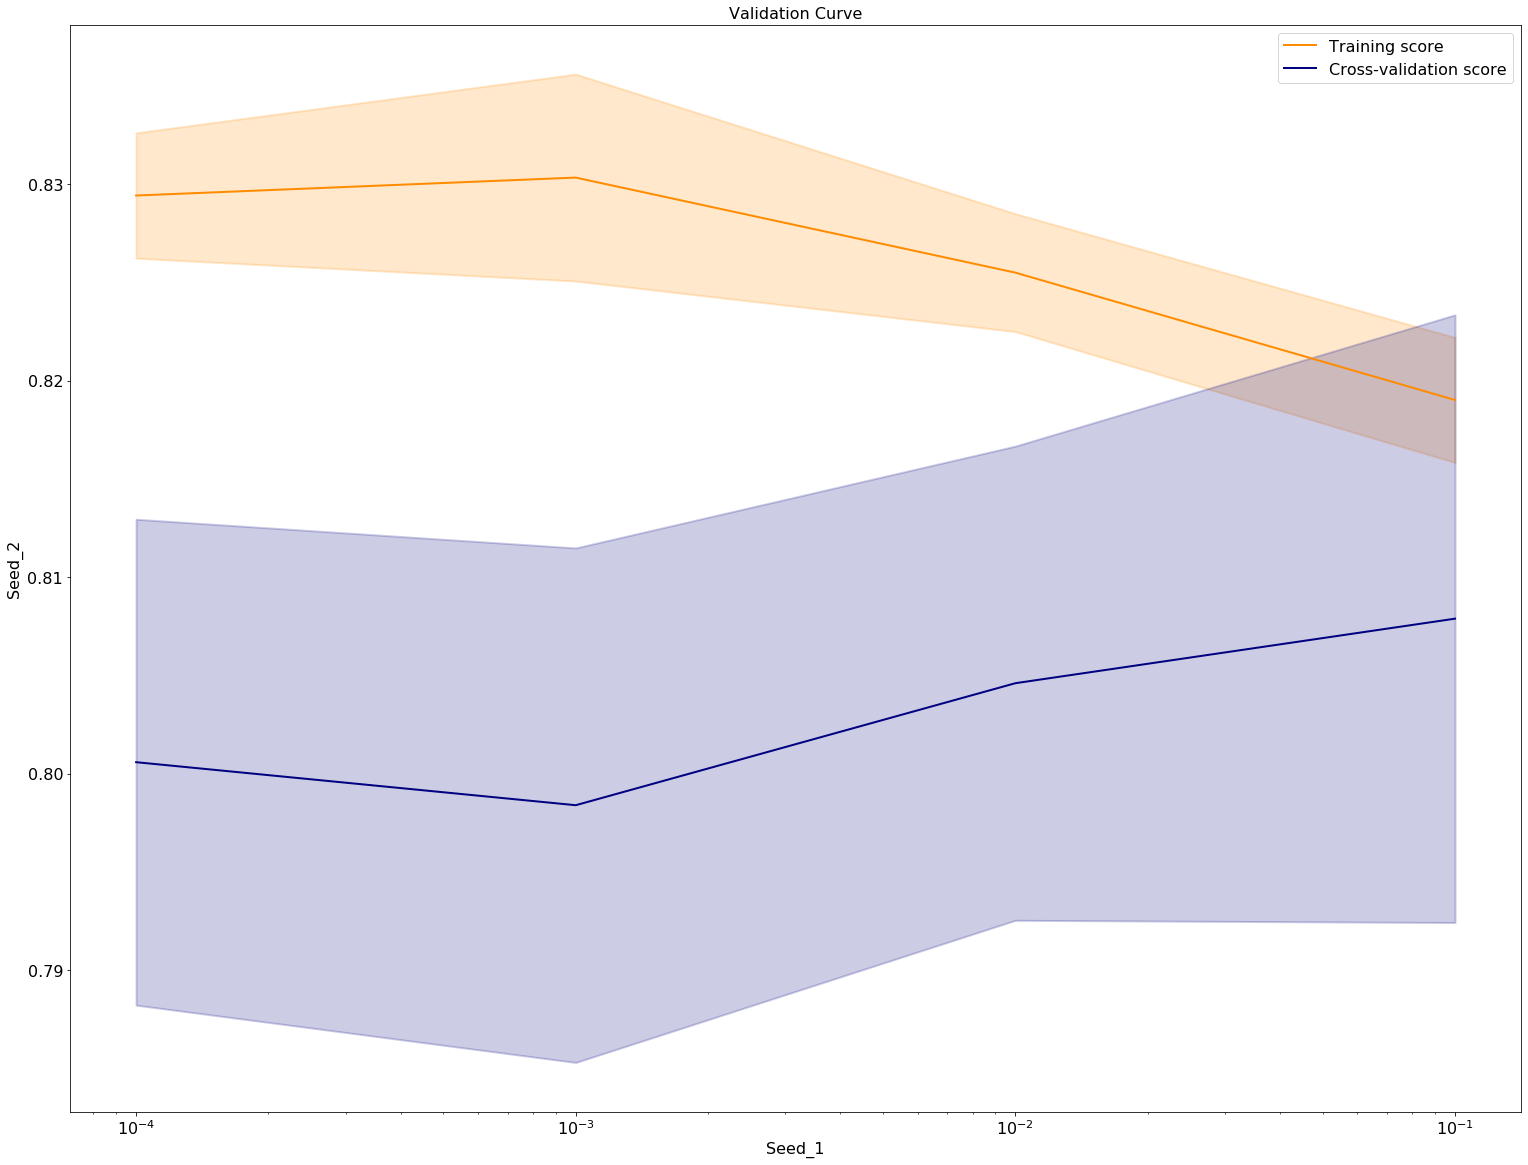

In [49]:
indices = np.arange(y.shape[0])
np.random.shuffle(indices)
X_shuffled, y_shuffled = X[indices], y[indices]

train_scores, valid_scores = validation_curve(best_estimator, X_shuffled, y_shuffled,
                                              param_to_be_varied_in_validation_curve,
                                              param_range_valid_curve,
                                              cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve")
plt.xlabel(best_feature_one)
plt.ylabel(best_feature_two)
lw = 2
plt.semilogx(param_range_valid_curve, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range_valid_curve, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range_valid_curve, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range_valid_curve, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

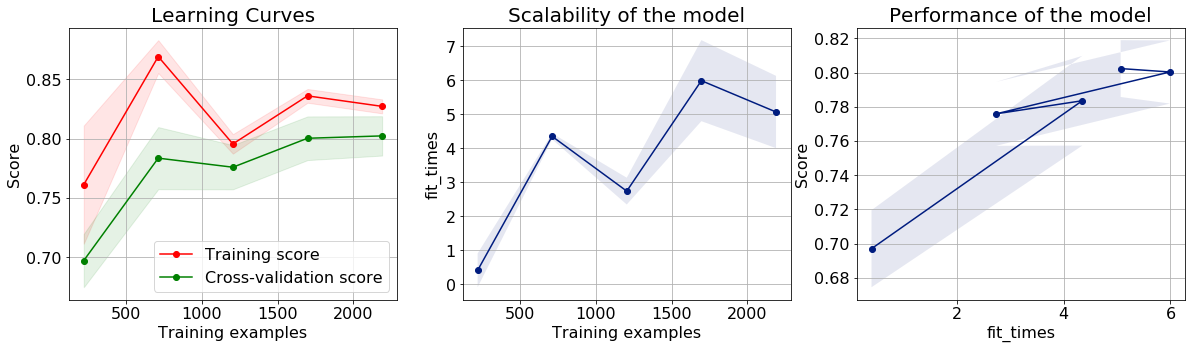

In [50]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    axes[0].title.set_fontsize(20)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")
    axes[1].title.set_fontsize(20)

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    axes[2].title.set_fontsize(20)

    return plt


title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = best_estimator
plot_learning_curve(estimator, title, X, y,cv=cv, n_jobs=-1)

plt.show()

### 8-Model export

In [51]:
if MODEL_EXPORT:
    from joblib import dump, load
    dump(best_estimator, MODEL_EXP_PATH)

### 9-Python and html generation

In [52]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

SyntaxError: invalid syntax (<ipython-input-52-a20682bb3efa>, line 3)

In [ ]:
if REPORT_GEN:
    import nbformat
    from nbconvert import PythonExporter
    import os
    import codecs
    from IPython.display import Javascript
    import time
    from nbconvert import HTMLExporter


    def convertNotebook(notebookPath, modulePath):

      with open(notebookPath) as fh:
        nb = nbformat.reads(fh.read(), nbformat.NO_CONVERT)

      exporter = PythonExporter()
      source, meta = exporter.from_notebook_node(nb)
      with open(modulePath, 'w+') as fh:
        fh.writelines(source)


    def save_notebook():
        display(
            Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript']
        )

    def output_HTML(read_file, output_file):
        exporter = HTMLExporter()
        # read_file is '.ipynb', output_file is '.html'
        output_notebook = nbformat.read(read_file, as_version=4)
        output, resources = exporter.from_notebook_node(output_notebook)
        codecs.open(output_file, 'w', encoding='utf-8').write(output)

    nb_full_path = os.path.join(os.getcwd(), theNotebook)
    convertNotebook(nb_full_path+".ipynb", OUTPUT_SCRIPT_NAME)

    save_notebook()
    time.sleep(3)
    current_file = theNotebook+".ipynb"
    output_HTML(current_file, OUTPUT_HTML_NAME)

### Test data predictions

In [ ]:
test_df = pd.read_csv('data/test.csv', infer_datetime_format=True, index_col=False, skipinitialspace=True)
test_df_to_use = test_df[input_features]

print(test_df_to_use.shape)

y_pred = best_estimator.predict_proba(test_df_to_use)
test_df['pred'] = y_pred
test_df = test_df['id','pred']

test_df.head()